In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from typing import Tuple, Sequence, Callable
import math

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Point net example
Just to show how this works, we check for a random point on a plane. 

In [11]:
num_points = 50

In [18]:
Point=Tuple[float, float]


def d(p1: Point, p2: Point) -> float:
    v = [(x-y)**2 for x,y in zip(p1, p2)]
    return np.sqrt(sum(v))

def d1(v1: Point, v2: Point) -> float:
     return np.sqrt(sum((v1-v2)**2))

def calculate_margin(points: Sequence[Point], labels: Sequence[int]) -> float:
    ones = filter(lambda a: a[1]==1,  zip(points, labels)) 
    zeros= filter(lambda a: a[1]==0,  zip(points, labels))
    min_dist = 10
    
    for o in ones:
        for z in zeros:
            if (dst:=d(o[0], z[0])) < min_dist:
                min_dist = dst
                
    return min_dist

def generate_net(points: Sequence[Point], gamma:float, d: Callable[[Point, Point], float]=d) -> Sequence[Point]:
    net = [points[np.random.randint(0, len(points))]]
    
    for p in points:
        insert = True
        for n in net: 
            if d(p, n) < gamma:
                insert = False
                break
        if insert:
            net.append(p)
        
    return net

def k_nearest(k, points, new_point, distance= d):
    byd = sorted(points, key=lambda lp: distance(lp, new_point))
    return byd[:k]

def plot_net(points, lables, gamma):
    gn = generate_net(points, gamma)
    nx, ny =list(zip(*gn))
    
    x, y =list(zip(*points))
    plt.scatter(nx, ny, s= 180,  c='r')
    plt.scatter(x, y, c=labels)
    

In [19]:
centers = [[1, 1], [-1, -1]]
X, y = make_blobs(n_samples=num_points, centers=centers, n_features=2, cluster_std=0.8, random_state=42)

points = list(zip(X[:, 0], X[:, 1]))
labels=y

In [20]:
g = calculate_margin(points, labels)
print(g)

1.4940589915175395


In [28]:
p = (1.61, 0.5)
gamma = g/2

kn = k_nearest(1, points, p)
net = generate_net(points, gamma)
nn = k_nearest(1, net, p)

print(f"Nearest neighbour using full point set ({len(points)}pts)\t=\t{kn}")
print(f"Nearest neighbour using point net      ({len(net)}pts)\t=\t{nn}")

Nearest neighbour using full point set (50pts)	=	[(1.397371322408986, 0.8893885590630523)]
Nearest neighbour using point net      (17pts)	=	[(1.397371322408986, 0.8893885590630523)]


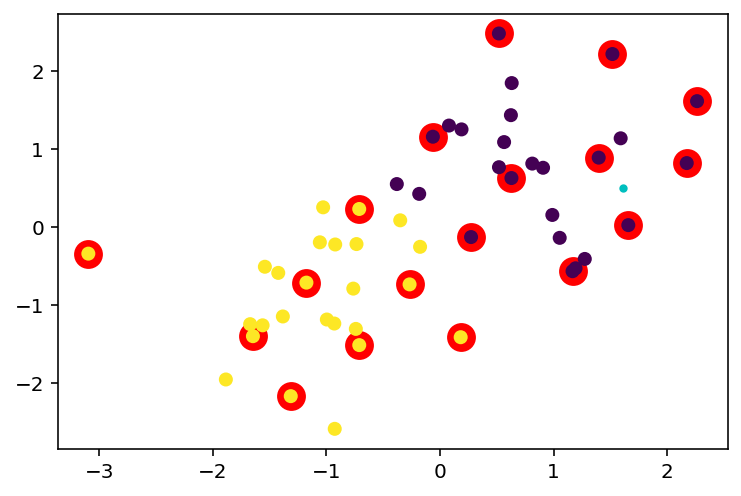

In [25]:
plot_net(points, y, gamma)
plt.scatter(p[0], p[1], s=10, c='c');

## app data
Some experiments using real data. Mostly discussing distance function (similarity)

In [2]:
from sklearn.model_selection import train_test_split
import tqdm

In [132]:
v = pd.read_csv('data/functions_encoded.csv')

In [4]:
smp = v.sample(1000, random_state=42)
smp.head(3)

,apn,nf,usage
26929367,4464,573964,1
26806321,18538,528917,1
33237401,6909,625812,4


In [5]:
ap1 = 9104
ap2 = 18261

def get_app_functions(apid, v):
    return set(v[v['apn']==apid].nf.values)


def app_distance(apid1, apid2, v) -> float:
    nf1 = get_app_functions(apid=apid1, v=v)
    nf2 = get_app_functions(apid=apid2, v=v)
    return 0.5 - len(nf1.intersection(nf2))/(len(nf1)+len(nf2))

def ad(apid1, apid2,v ) -> float:
    p1 = get_app_functions(apid=apid1, v=v)
    p2 = get_app_functions(apid=apid2, v=v)
    
    a= len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

assert app_distance(ap1, ap1, v=smp) == 0.0
assert app_distance(ap1, ap2, v=smp) == 0.5
assert ad(ap1, ap2, v=smp) == ad(ap2, ap1, v=smp)
assert ad(ap1, ap1, v=smp) == ad(ap2, ap2, v=smp) == 0

In [6]:
funcs = v.groupby(by='apn')['nf'].apply(set)
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)

In [7]:
def adf(apid1, apid2,funcs ) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]
    
    a= len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

adff = lambda x,y,z=funcs: adf(x,y, funcs)

assert adff(ap1,ap1) == adff(ap2, ap2) == 0
assert adff(ap1, ap2) == adff(ap2, ap1)

In [8]:
adff(ap1, ap2), ad(ap1, ap2, v)

(164.72401160729422, 164.72401160729422)

In [12]:
#lets call it curse of dimensionality: the more dimensions (funcs) the larger the distance
adf(ap1, ap2, funcs_smp), adf(ap1, ap2, funcs)

(1.7320508075688772, 164.72401160729422)

In [13]:
def create_net(gamma:float, v, distance=app_distance) -> Sequence[int]:
    apns = v.apn.unique()
    np.random.shuffle(apns)
    net = []

    for a in apns:
        insert = True
        for n in net: 
            if distance(a, n, v) < gamma:
                insert = False
                break
        if insert:
            net.append(a)
            
    return net


In [15]:
net = create_net(gamma = 1.4, v = smp, distance=lambda x,y,z: adf(x,y,funcs_smp))
#net

In [16]:
len(net), len(smp)

(845, 1000)

In [17]:
train, test = train_test_split(smp)

In [18]:
net = create_net(gamma=1.4, v= train, distance=lambda x,y, v: adf(x, y, funcs_smp))

In [19]:
len(net), len(train)

(662, 750)

## Experiments with KNN
It only shows that KNN without labels (i.e., not classifying) does not make much sense in the current metric space. The nn found on net is in the same distance as the one foudn on the full dataset. Thoes nn can have however different id (different apps), the distance distribution is not on our side here. Many points are at the same distance.

In [20]:
def app_k_nearest(k, apps, new_app, distance):
    byd = sorted(apps, key=lambda lp: distance(lp, new_app))
    return byd[:k]

In [33]:
apns = smp.apn.unique()
p = test.iloc[2]['apn']

In [22]:
mydistfunc = lambda x,y: adf(x, y, funcs_smp)
k=1000

In [43]:
print(f"Nearest neigbours of {p} calcluated with whole dataset ({len(apns)} pts) ")
w = app_k_nearest(k=k, apps=apns, new_app = p, distance=mydistfunc)
print(f"closest neighbour: {w[0]} at {mydistfunc(p, w[1])}")  #exclude the seaerched point
dsts = {a: mydistfunc(p, a) for a in w if a!=p}
max_dst = max(dsts.values())
min_dst = min(dsts.values())
print(max_dst, min_dst)
print(f"Points at min distance: {len([a for a,b in dsts.items() if b==min_dst])}");

Nearest neigbours of 9814 calcluated with whole dataset (851 pts) 
closest neighbour: 9814 at 1.4142135623730951
2.23606797749979 1.4142135623730951
Points at min distance: 726


In [45]:
print(f"Nearest neigbours of {p} calcluated with net ({len(net)} pts)")
n = app_k_nearest(k=k, apps=net, new_app=p, distance=mydistfunc)
print(f"closest neighbour: {n[0]} at {mydistfunc(p, n[0])}")
net_dsts = {a: mydistfunc(p, a) for a in n}
net_max_dist = max(net_dsts.values())
net_min_dist = min(net_dsts.values())
print(net_max_dist, net_min_dist)
print(f"Points at min distance: {len([a for a,b in net_dsts.items() if b==net_min_dist])}");

Nearest neigbours of 9814 calcluated with net (662 pts)
closest neighbour: 8880 at 1.4142135623730951
2.23606797749979 1.4142135623730951
Points at min distance: 550


#### Distance distribution in set

Counter({1.4142135623730951: 527798, 1.7320508075688772: 148302, 2.0: 37926, 2.23606797749979: 8238, 2.449489742783178: 954, 2.6457513110645907: 114, 2.8284271247461903: 6, 0.0: 6, 1.0: 6})


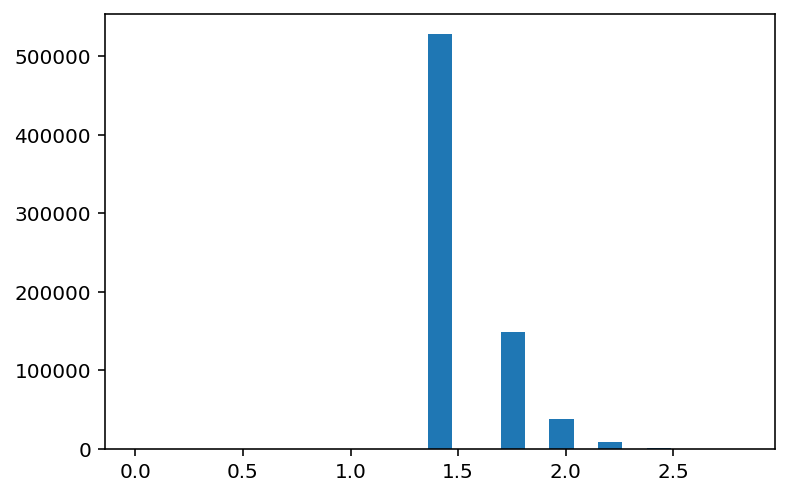

In [54]:
from collections import Counter

# all pairwise distances except self to self
def calculate_distances(smp, distance: Callable)->Sequence[float]:
    distances = []
    for o in smp.apn.unique():
        for z in smp.apn.unique():
            if o == z:
                continue
            distances.append(distance(o, z, smp))
    return distances

#all distances with labels ignored:
distances = calculate_distances(smp, distance=lambda x,y,z: adf(x,y, funcs_smp))
c = Counter(distances)
print(c)
plt.hist(distances, bins=25);


## With labels
* calcualte margin: minimal distance between differently labelled points
* check network performance

In [46]:
labels = pd.read_csv('./data/labels_encoded.csv')

In [48]:
# split smp according to label (malicious or not)
def split_mal(smp, labels):
    benid = labels[labels.malware_label==False]['apn'].values
    malid = labels[labels.malware_label==True]['apn'].values

    mals = smp[smp.apn.isin(malid)]
    bi = smp[smp.apn.isin(benid)]
    
    return (mals, bi)

mals, bi = split_mal(smp, labels)
assert(mals.shape[0]+bi.shape[0] == smp.shape[0])

In [202]:
#minimal distance between differently labelled data points
def calculate_margin(smp, labels, distance: Callable) -> float:
    mals, beni = split_mal(smp, labels)
    print(f"Split finished: {mals.shape} {beni.shape} {smp.shape}")
    min_dist = float('inf')
    problematic = []

    for o in beni.apn.unique():
        for z in mals.apn.unique():
            if (d:=distance(o, z, smp)) < min_dist:
                if d == 0:
                    print(f"Got minimal distance of 0 between {o}<->{z}. ignoring.")
                    problematic.append((o,z))
                else:
                    min_dist = d
                
                
    print(f"Problematic cases: {problematic}")
    return min_dist 

In [56]:
# margin:
## funcs_smp uses only functions in sample
margin = calculate_margin(smp, labels, distance=lambda x,y,z: adf(x,y, funcs_smp))

Got minimal distance of 0 between 599<->4262. breaking


In [66]:
# difference between sample and full dataset. 
# two "identical" apps in sample (one and only funciton common), are different in full dataset
smp[smp.apn.isin([599, 4262])].shape, v[v.apn.isin([599, 4262])].shape

((2, 3), (14070, 3))

In [69]:
adf(599, 4262, funcs_smp), adf(599, 4262, funcs)

(0.0, 114.85643212288984)

In [126]:
import random

def mysample(v, sample_size):
    r = random.sample(list(v.apn.unique()), k=sample_size)
    #apns = v.apn.unique sample(sample_size, random_state=42)
    return v[v.apn.isin(r)][['apn', 'nf']]

In [187]:
def margins(v, labels, sample_size, problematic=[]):
    smp = mysample(v, sample_size) #v.sample(sample_size, random_state=42)
    print(f"sample created {smp.shape[0]/v.shape[0]:.2f}")
    if len(problematic)>0:
        print(f"Removing problematic {len(problematic)} apps")
        smp = smp[~smp.apn.isin(problematic)]
        
    funcs_smp = smp.groupby(by='apn')['nf'].apply(set)
    margin = calculate_margin(smp, labels, distance=lambda x,y,z: adf(x,y, funcs_smp))
    return margin

In [204]:
import itertools
problematic_pairs = [(20353, 11822), (20353, 5960), (20353, 5279), (20353, 23352), (20353, 4508), (20353, 15342), (20353, 2049), (20353, 15167), (20353, 22414), (20353, 9094), (20353, 25173), (20353, 7987), (20353, 10025), (20353, 5217), (20353, 9950), (20353, 24486), (20353, 17737), (20353, 17091), (20353, 24216), (20353, 23845), (20353, 6845), (20353, 25822), (20353, 4544), (20353, 5104), (20353, 1342), (20353, 16752), (20353, 17521), (20353, 5748), (20353, 21368), (20353, 23385), (20353, 24937), (20353, 10917), (20353, 27580), (20353, 17441), (20353, 16741), (20353, 4207), (20353, 8831), (20353, 22246), (20353, 15939), (20353, 21521), (20353, 14873), (20353, 4419), (20353, 23693), (20353, 12381), (20353, 23648), (20353, 12363), (20353, 22947), (20353, 22142), (20353, 17493), (20353, 13548), (20353, 14005), (20353, 14118), (20353, 17489), (20353, 11314), (20353, 23366), (20353, 24831), (20353, 12600), (20353, 22022), (20353, 17768), (20353, 23425), (20353, 21211), (20353, 3520), (20353, 10499), (20353, 16335), (20353, 26645), (20353, 16786), (20353, 4553), (20353, 15159), (20353, 10735), (20353, 2865), (20353, 440), (20353, 1441), (20353, 6307), (20353, 1503), (20353, 24948), (20353, 7846), (20353, 17565), (20353, 21973), (20353, 21833), (20353, 22007), (20353, 22165), (20353, 16663), (20353, 5525), (20353, 6969), (20353, 13086), (20353, 9158), (20353, 21508), (20353, 22015), (20353, 8245), (20353, 5230), (20353, 24770), (20353, 1785), (20353, 10814), (20353, 7186), (20353, 1638), (20353, 25910), (20353, 23679), (20353, 22521), (20353, 929), (20353, 465), (20353, 154), (20353, 24845), (20353, 5108), (20353, 22169), (20353, 15855), (20353, 22805), (20353, 10557), (20353, 4718), (20353, 23042), (20353, 16932), (20353, 805), (20353, 13492), (20353, 25587), (20353, 22874), (20353, 23334), (20353, 360), (20353, 2081), (20353, 23961), (20353, 22848), (20353, 16955), (20353, 6856), (20353, 2258), (20353, 27284), (20353, 13875)]
problematic = list(itertools.chain(*problematic_pairs))

In [205]:
margins(v, labels, sample_size=1000, problematic=problematic)

sample created 0.10
Removing problematic 248 apps
Split finished: (992831, 2) (2360350, 2) (3353181, 2)
Got minimal distance of 0 between 11323<->8945. ignoring.
Got minimal distance of 0 between 11323<->12966. ignoring.
Got minimal distance of 0 between 11323<->8551. ignoring.
Got minimal distance of 0 between 11323<->11160. ignoring.
Got minimal distance of 0 between 11323<->5037. ignoring.
Got minimal distance of 0 between 11323<->21577. ignoring.
Got minimal distance of 0 between 11323<->7892. ignoring.
Got minimal distance of 0 between 11323<->26866. ignoring.
Got minimal distance of 0 between 11323<->11368. ignoring.
Got minimal distance of 0 between 11323<->24912. ignoring.
Got minimal distance of 0 between 11323<->16736. ignoring.
Got minimal distance of 0 between 11323<->12624. ignoring.
Got minimal distance of 0 between 11323<->1353. ignoring.
Got minimal distance of 0 between 11323<->8674. ignoring.
Got minimal distance of 0 between 11323<->6421. ignoring.
Got minimal distan

Problematic cases: [(11323, 8945), (11323, 12966), (11323, 8551), (11323, 11160), (11323, 5037), (11323, 21577), (11323, 7892), (11323, 26866), (11323, 11368), (11323, 24912), (11323, 16736), (11323, 12624), (11323, 1353), (11323, 8674), (11323, 6421), (11323, 12169), (11323, 7541), (11323, 2491), (11323, 881), (11323, 6525), (11323, 2790), (11323, 9262), (11323, 174), (11323, 26456), (11323, 4280), (11323, 16724), (11323, 9631), (11323, 1523), (11323, 13116), (11323, 10709), (11323, 24879), (11323, 25311), (11323, 7007), (11323, 21505), (11323, 25259), (11323, 996), (11323, 5074), (11323, 11708), (11323, 3666), (11323, 5021), (11323, 437), (11323, 12144), (11323, 712), (11323, 1552), (11323, 17699), (11323, 3626), (11323, 21132), (11323, 27340), (11323, 21572), (11323, 1449), (11323, 11543), (11323, 26276), (11323, 26682), (11323, 7082), (11323, 22740), (11323, 3309), (11323, 1740), (11323, 21105), (11323, 17749), (11323, 22829), (11323, 16443), (11323, 25918), (11323, 7843), (11323, 

1.0

In [207]:
margins(v, labels, sample_size=100, problematic=problematic)

sample created 0.01
Removing problematic 248 apps
Split finished: (131986, 2) (260697, 2) (392683, 2)
Problematic cases: []


1.4142135623730951

### Probalemtic cases
Some applications are identical in our dimension space (use exactly the same funciton). Yet they are differently classfied (malware and not).

In [168]:
def show_problematic(v, labels, id1, id2):
    print(f"App {id1} malware=[{labels[labels.apn==id1]['malware_label'].values[0]}] \tuses: {sorted(v[v.apn==id1]['nf'].values)}")
    print(f"App {id2} malware=[{labels[labels.apn==id2]['malware_label'].values[0]}] \tuses: {sorted(v[v.apn==id2]['nf'].values)}")
    

In [206]:
for (a, b) in problematic_pairs:
    show_problematic(v, labels, a, b)
    print()

App 20353 malware=[False] 	uses: [101925, 178583]
App 11822 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 5960 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 5279 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 23352 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 4508 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 15342 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 2049 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 15167 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 22414 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 9094 malware=[True] 	uses: [101925, 178583]

App 2

App 5525 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 6969 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 13086 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 9158 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 21508 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 22015 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 8245 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 5230 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 24770 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 1785 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 10